In [65]:
import tensorflow as tf
import os
import numpy as np
import random
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import  resize
import matplotlib.pyplot as plt

In [66]:
seed = 42
np.random.seed = seed

In [67]:
TRAIN_PATH = 'datasets/data-science-bowl-2018/stage1_train/'
TEST_PATH = 'datasets/data-science-bowl-2018/stage1_test/'

In [68]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [69]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [70]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print(X_train.shape)
print(Y_train.shape)

(670, 128, 128, 3)
(670, 128, 128, 1)


In [71]:
print('Resizing training images and masks')

for n, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT,IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

    # Combining the mask images, taking the maximum pixel value across all the mask images. 
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT,IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    Y_train[n] = mask

Resizing training images and masks


100%|██████████| 670/670 [02:29<00:00,  4.47it/s]


In [72]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Resizing test images


100%|██████████| 65/65 [00:00<00:00, 74.56it/s]


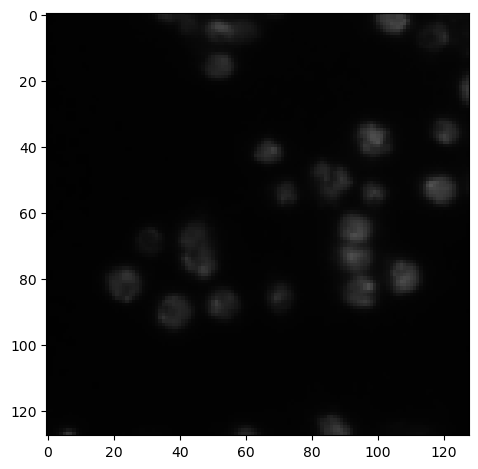

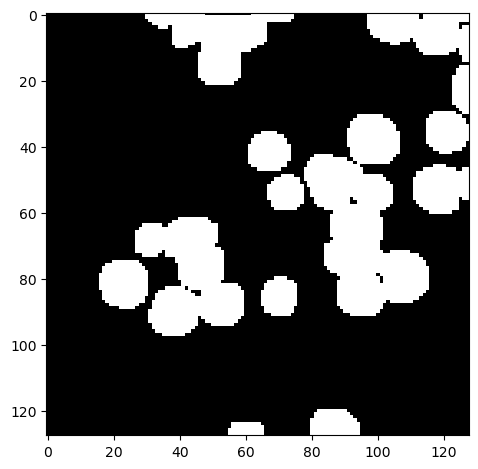

In [73]:
# Plotting some of the images

image_x = random.randint(0,len(train_ids))
imshow(X_train[image_x])
plt.show()

imshow(Y_train[image_x])

In [74]:
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x:x/255)(inputs)   # converting int inputs to floating points.

In [75]:
# Contraction Path

c1 = tf.keras.layers.Conv2D(16,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPool2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPool2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPool2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPool2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)


# Expansion Path

u6 = tf.keras.layers.Conv2DTranspose(128,(2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.Concatenate()([u6,c4])
c6 = tf.keras.layers.Conv2D(128,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64,(2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.Concatenate()([u7,c3])
c7 = tf.keras.layers.Conv2D(64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32,(2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.Concatenate()([u8,c2])
c8 = tf.keras.layers.Conv2D(32,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16,(2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.Concatenate()([u9,c1])
c9 = tf.keras.layers.Conv2D(16,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1,(1,1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  448         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

In [76]:
# Model Checkpoints

chcekpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

# callbacks
callbacks = [
                tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
                tf.keras.callbacks.TensorBoard(log_dir='logs')
            ]

In [77]:
results = model.fit(X_train,Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<16x128x128x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<16x64x64x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerfo

37/38 [============================>.] - ETA: 0s - loss: 0.5348 - accuracy: 0.7744

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<11x128x128x16xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<11x64x64x32xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerfo

38/38 [==============================] - ETA: 0s - loss: 0.5336 - accuracy: 0.7765

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<16x128x128x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<16x128x128x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerfo

38/38 [==============================] - 42s 641ms/step - loss: 0.5336 - accuracy: 0.7765 - val_loss: 0.3058 - val_accuracy: 0.8925
Epoch 2/25
38/38 [==============================] - 5s 121ms/step - loss: 0.2722 - accuracy: 0.8841 - val_loss: 0.1888 - val_accuracy: 0.9273
Epoch 3/25
38/38 [==============================] - 4s 118ms/step - loss: 0.1708 - accuracy: 0.9374 - val_loss: 0.1454 - val_accuracy: 0.9439
Epoch 4/25
38/38 [==============================] - 4s 117ms/step - loss: 0.1432 - accuracy: 0.9446 - val_loss: 0.1580 - val_accuracy: 0.9423
Epoch 5/25
38/38 [==============================] - 5s 123ms/step - loss: 0.1305 - accuracy: 0.9491 - val_loss: 0.1104 - val_accuracy: 0.9572
Epoch 6/25
38/38 [==============================] - 5s 119ms/step - loss: 0.1173 - accuracy: 0.9544 - val_loss: 0.1132 - val_accuracy: 0.9571
Epoch 7/25
38/38 [==============================] - 5s 120ms/step - loss: 0.1160 - accuracy: 0.9557 - val_loss: 0.1088 - val_accuracy: 0.9572
Epoch 8/25
38/38

In [78]:
idx = random.randint(0,len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 3s 2s/step


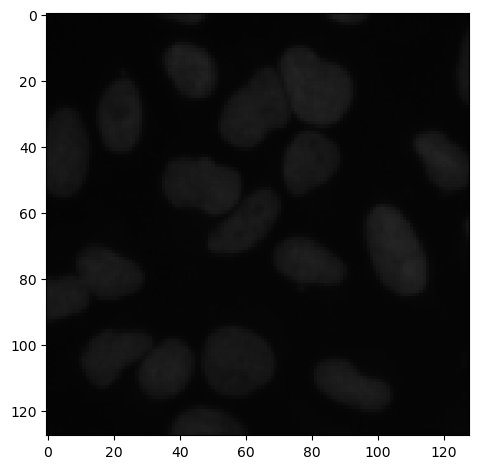

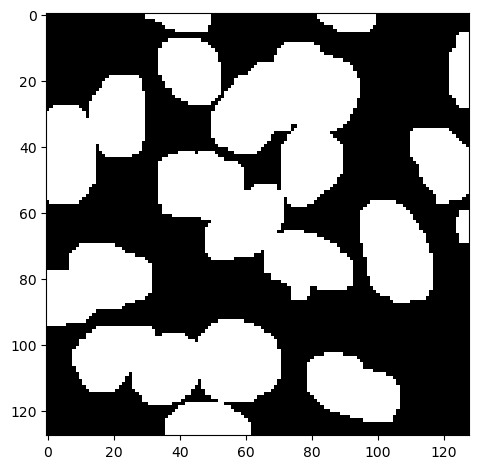

/Users/ashwin/miniconda3/envs/tensorflow/lib/python3.10/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


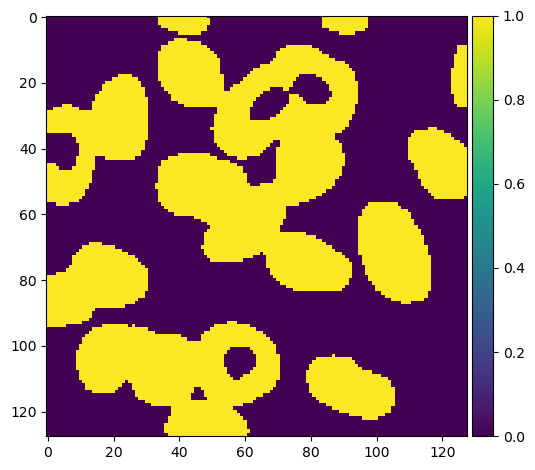

In [79]:
# Sanity check on random training sample

ix = random.randint(0,len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

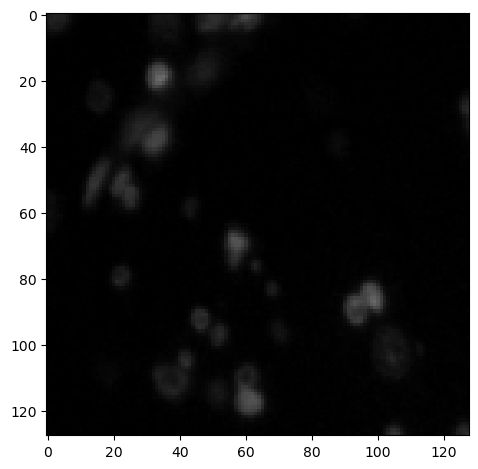

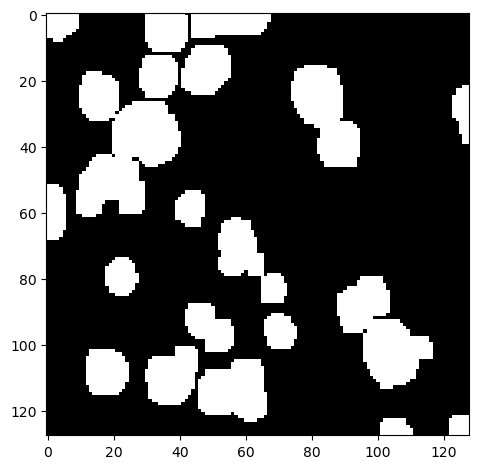

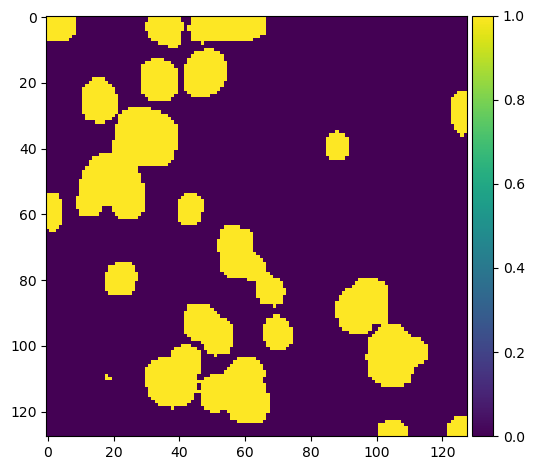

In [80]:
# Sanity check on random validation sample

ix = random.randint(0,len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [83]:
!tensorboard --logdir=logs/ --host localhost --port 8088

TensorBoard 2.12.3 at http://localhost:8088/ (Press CTRL+C to quit)
^C
